# SARIMAX

## 1. Setup

Load the data:

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed")

# Load actual generation data
df_observed = pd.read_csv(
    os.path.join(data_dir, "bmrs_data.csv"),
    parse_dates=["SETTLEMENT_DATE"],
)

# Load generation forecasts
df_forecasts = pd.read_csv(
    os.path.join(data_dir, "neso_forecasts.csv"),
    parse_dates=["TARGET_DATE", "ISSUE_DATE"],
)

# Load gas prices
df_gas_price = pd.read_csv(
    os.path.join(data_dir, "gas_prices.csv"),
    parse_dates=["SETTLEMENT_DATE"],
)

if df_observed.isna().values.any():
    print("Warning: BMRS dataset contains null values.")

if df_forecasts.isna().values.any():
    print("Warning: NESO dataset contains null values.")

if df_gas_price.isna().values.any():
    print("Warning: Gas price dataset contains null values.")

Convert settlement dates and periods to timestamps:

In [2]:
from utilities.datatools import create_timestamps

df_observed["TIMESTAMP"] = create_timestamps(
    df_observed,
    date_column="SETTLEMENT_DATE",
    period_column="SETTLEMENT_PERIOD",
    tz="UTC"
)
df_observed = df_observed.drop(columns=["SETTLEMENT_DATE", "SETTLEMENT_PERIOD"])

df_forecasts["TIMESTAMP"] = create_timestamps(
    df_forecasts,
    date_column="TARGET_DATE",
    period_column="TARGET_PERIOD",
    tz="UTC",
)
df_forecasts = df_forecasts.drop(columns=["TARGET_DATE", "TARGET_PERIOD"])

df_gas_price["TIMESTAMP"] = df_gas_price["SETTLEMENT_DATE"].dt.tz_localize("UTC")
df_gas_price = df_gas_price.drop(columns=["SETTLEMENT_DATE"])

Merge gas prices with training data:

In [3]:
df_train = df_observed.merge(df_gas_price, on="TIMESTAMP", how="left")
df_train["NATURAL_GAS_PRICE"] = df_train["NATURAL_GAS_PRICE"].ffill()
df_train = df_train.rename(columns={"INDO": "DEMAND"})

df_train = df_train.set_index("TIMESTAMP")
df_train.index = df_train.index.round('30min')
df_train = df_train.asfreq('30min')

if df_train.index.duplicated().any():
    print("WARNING: Found duplicate indices")

if df_train.isna().values.any():
    print("WARNING: Found null values")

df_train.head()

,BIOMASS,GAS,COAL,OIL,NUCLEAR,SOLAR,WIND,OTHER,INTER,DEMAND,ITSO,ELECTRICITY_PRICE,TRADING_VOLUME,NATURAL_GAS_PRICE
TIMESTAMP,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,3116.0,11268.0,0.0,0.0,5949.0,0.0,4734.688,576.0,3428.0,28263.0,28880.0,68.54,407.30,19.499
2021-01-01 00:30:00+00:00,3118.0,11526.0,0.0,0.0,5956.0,1.0,4524.192,569.0,3572.0,28403.0,29018.0,69.82,601.40,19.499
2021-01-01 01:00:00+00:00,3087.0,11240.0,0.0,0.0,5948.0,1.0,4423.037,535.0,3570.0,27633.0,28252.0,67.42,608.00,19.499
2021-01-01 01:30:00+00:00,3117.0,10365.0,0.0,0.0,5950.0,0.0,4309.821,521.0,3568.0,26768.0,27625.0,65.45,579.35,19.499
2021-01-01 02:00:00+00:00,3113.0,10020.0,0.0,0.0,5949.0,0.0,4306.346,517.0,3512.0,25876.0,27051.0,59.44,729.40,19.499


In [4]:
# Locate the null values
nan_rows = df_train[df_train.isna().any(axis=1)]

print(f'NUMBER OF NULL ROWS: {len(nan_rows)} out of {len(df_train)}')

print("HEAD OF NULL ROWS:")
print(nan_rows.head().to_string())
print("\nTAIL OF NULL ROWS:")
print(nan_rows.tail().to_string())

NUMBER OF NULL ROWS: 1920 out of 70128
HEAD OF NULL ROWS:
                           BIOMASS  GAS  COAL  OIL  NUCLEAR  SOLAR  WIND  OTHER  INTER  DEMAND  ITSO  ELECTRICITY_PRICE  TRADING_VOLUME  NATURAL_GAS_PRICE
TIMESTAMP                                                                                                                                                 
2021-02-16 00:00:00+00:00      NaN  NaN   NaN  NaN      NaN    NaN   NaN    NaN    NaN     NaN   NaN                NaN             NaN                NaN
2021-02-16 00:30:00+00:00      NaN  NaN   NaN  NaN      NaN    NaN   NaN    NaN    NaN     NaN   NaN                NaN             NaN                NaN
2021-02-16 01:00:00+00:00      NaN  NaN   NaN  NaN      NaN    NaN   NaN    NaN    NaN     NaN   NaN                NaN             NaN                NaN
2021-02-16 01:30:00+00:00      NaN  NaN   NaN  NaN      NaN    NaN   NaN    NaN    NaN     NaN   NaN                NaN             NaN                NaN
2021-02-16 0

Shift natural gas price back by two days for use in day-ahead forecasts:

In [5]:
df_gas_price_forecast = df_gas_price.copy()
df_gas_price["NATURAL_GAS_PRICE"] = df_gas_price["NATURAL_GAS_PRICE"].shift(-2)
df_test = df_forecasts.merge(df_gas_price, on="TIMESTAMP", how="left")
df_test["NATURAL_GAS_PRICE"] = df_test["NATURAL_GAS_PRICE"].ffill()

df_test = df_test.set_index("TIMESTAMP")
df_test.index = df_test.index.round('30min')
df_test = df_test.asfreq('30min')

if df_test.index.duplicated().any():
    print("WARNING: Found duplicate indices")

if df_test.isna().values.any():
    print("WARNING: Found null values")

df_test.head()

,ISSUE_DATE,DEMAND_FORECAST,WIND_FORECAST,WIND_CAPACITY,EMBEDDED_WIND_FORECAST,EMBEDDED_SOLAR_FORECAST,ISSUE_PERIOD,NATURAL_GAS_PRICE
TIMESTAMP,,,,,,,,
2021-01-02 00:00:00+00:00,2021-01-01,26217.740741,2383.0,15729.0,879.0,0.0,18.0,20.391
2021-01-02 00:30:00+00:00,2021-01-01,26622.000000,2382.0,15729.0,867.0,0.0,18.0,20.391
2021-01-02 01:00:00+00:00,2021-01-01,26829.592593,2398.0,15729.0,867.0,0.0,18.0,20.391
2021-01-02 01:30:00+00:00,2021-01-01,26906.074074,2429.0,15729.0,863.0,0.0,18.0,20.391
2021-01-02 02:00:00+00:00,2021-01-01,26917.000000,2474.0,15729.0,863.0,0.0,18.0,20.391


In [6]:
# Locate the null values
nan_rows = df_test[df_test.isna().any(axis=1)]

print(f'NUMBER OF NULL ROWS: {len(nan_rows)} out of {len(df_test)}')

print("HEAD OF NULL ROWS:")
print(nan_rows.head().to_string())
print("\nTAIL OF NULL ROWS:")
print(nan_rows.tail().to_string())

NUMBER OF NULL ROWS: 6240 out of 70080
HEAD OF NULL ROWS:
                          ISSUE_DATE  DEMAND_FORECAST  WIND_FORECAST  WIND_CAPACITY  EMBEDDED_WIND_FORECAST  EMBEDDED_SOLAR_FORECAST  ISSUE_PERIOD  NATURAL_GAS_PRICE
TIMESTAMP                                                                                                                                                            
2022-12-02 00:00:00+00:00        NaT              NaN            NaN            NaN                     NaN                      NaN           NaN                NaN
2022-12-02 00:30:00+00:00        NaT              NaN            NaN            NaN                     NaN                      NaN           NaN                NaN
2022-12-02 01:00:00+00:00        NaT              NaN            NaN            NaN                     NaN                      NaN           NaN                NaN
2022-12-02 01:30:00+00:00        NaT              NaN            NaN            NaN                     NaN     

## 2. Feature engineering

Keep only desired columns and standardise names:

In [7]:
df_train = df_train[
    ["ELECTRICITY_PRICE", "WIND", "SOLAR", "DEMAND", "NATURAL_GAS_PRICE"]
]

df_test = df_test[
    ["WIND_FORECAST", "EMBEDDED_SOLAR_FORECAST",
    "DEMAND_FORECAST", "NATURAL_GAS_PRICE"]
]

df_test = df_test.rename(columns={
    "WIND_FORECAST": "WIND",
    "EMBEDDED_SOLAR_FORECAST": "SOLAR",
    "DEMAND_FORECAST": "DEMAND"
})

In [8]:
import holidays

def create_temporal_features(df: pd.DataFrame, local_time_col: str) -> pd.DataFrame:
    local_timestamps = df[local_time_col]

    hour = local_timestamps.dt.hour
    df["hour_sin"] = np.sin(4 * np.pi * (hour - 1) / 24)
    df["hour_cos"] = np.cos(4 * np.pi * (hour - 1) / 24)

    dow = local_timestamps.dt.dayofweek
    df["dayofweek_sin"] = np.sin(2 * np.pi * dow / 7)
    df["dayofweek_cos"] = np.cos(2 * np.pi * dow / 7)
    df["is_weekend"] = dow.isin([5, 6]).astype(int)

    gb_holidays = holidays.country_holidays(country="GB")
    dates = local_timestamps.dt.date
    check_holidays = np.vectorize(lambda date_: date_ in gb_holidays)
    df["is_holiday"] = check_holidays(dates).astype(int)

    month = local_timestamps.dt.month
    df["month_sin"] = np.sin(2 * np.pi * (month - 1) / 12)
    df["month_cos"] = np.cos(2 * np.pi * (month - 1) / 12)

    return df

In [9]:
df_train["LOCAL_TIME"] = df_train.index.tz_convert('Europe/London')
df_train = create_temporal_features(df_train, "LOCAL_TIME")
df_train = df_train.drop(columns=["LOCAL_TIME"])

df_test["LOCAL_TIME"] = df_test.index.tz_convert('Europe/London')
df_test = create_temporal_features(df_test, "LOCAL_TIME")
df_test = df_test.drop(columns=["LOCAL_TIME"])

## 3. Make a point forecast

Train-test split:

In [10]:
import datetime

train_dates = pd.date_range(
    start=datetime.date(year=2024, month=11, day=1),
    end=datetime.date(year=2024, month=11, day=7),
    tz="UTC",
    freq='30min',
    normalize=True,
    inclusive="left"
)

test_dates = pd.date_range(
    start=datetime.date(year=2024, month=11, day=7),
    end=datetime.date(year=2024, month=11, day=9),
    tz="UTC",
    freq='30min',
    normalize=True,
    inclusive="left"
)

# Endogenous variable
endog_train = df_train.loc[train_dates, "ELECTRICITY_PRICE"]
endog_test = df_train.loc[test_dates, "ELECTRICITY_PRICE"]

# Exogenous variables
exog_train = df_train.loc[train_dates].drop(columns=["ELECTRICITY_PRICE"])
exog_test = df_test.loc[test_dates]

Specify and train model:

In [22]:
import statsmodels.api as sm

order = (1, 0, 1)
seasonal_order = (1, 0, 1, 48)

model = sm.tsa.SARIMAX(
    endog=endog_train,
    order=order,
    seasonal_order=seasonal_order,
    exog=exog_train,
)

model_fitted = model.fit()

Plot residuals from training:

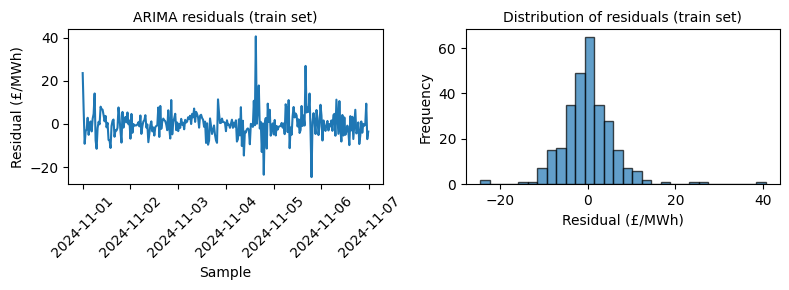

In [23]:
# Visualise training residuals
train_resid = model_fitted.resid

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")
ax1.plot(train_resid, label="Residuals")
ax1.set_xlabel("Sample", fontsize=10)
ax1.set_ylabel("Residual (£/MWh)", fontsize=10)
ax1.set_title("ARIMA residuals (train set)", fontsize=10)
ax1.tick_params(axis="x", labelrotation=45)

ax2.hist(train_resid, bins=30, edgecolor="black", alpha=0.7)
ax2.set_xlabel("Residual (£/MWh)", fontsize=10)
ax2.set_ylabel("Frequency", fontsize=10)
ax2.set_title("Distribution of residuals (train set)", fontsize=10)
plt.show()

Make a forecast:

RMSE: 17.82 £/MWh
MAE: 14.46 £/MWh


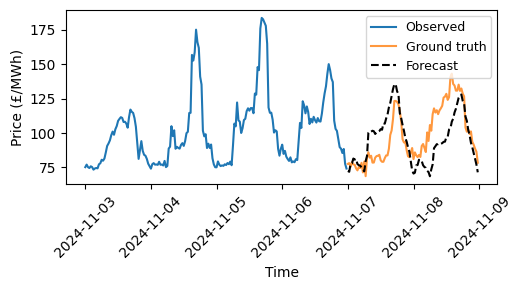

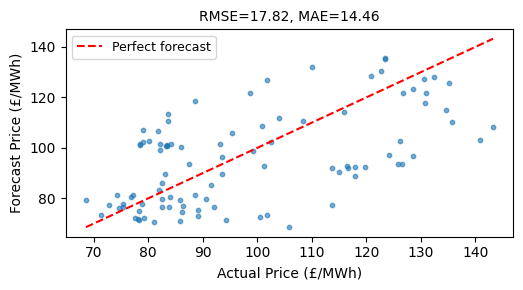

In [24]:
from utilities.evaluation import rmse, mae

point_forecast = model_fitted.forecast(steps=len(endog_test), exog=exog_test)
print(f"RMSE: {rmse(point_forecast, np.asarray(endog_test)):.2f} £/MWh")
print(f"MAE: {mae(point_forecast, np.asarray(endog_test)):.2f} £/MWh")

y_pred = np.asarray(point_forecast)
y_true = np.asarray(endog_test)
_rmse = rmse(y_pred, y_true)
_mae = mae(y_pred, y_true)

fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="tight")
ax.plot(endog_train.iloc[-(2 * len(endog_test)) :], label="Observed")
ax.plot(endog_test, label="Ground truth", alpha=0.8)
ax.plot(point_forecast, ls="--", color="k", label="Forecast")
ax.set_xlabel("Time", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
ax.tick_params(axis="x", labelrotation=45)
ax.legend(fontsize=9)
plt.show()


fig, ax = plt.subplots(figsize=(16 / 3, 3), layout="tight")
scatter = ax.scatter(endog_test, point_forecast, alpha=0.6, s=10)
ax.plot(
    [endog_test.min(), endog_test.max()],
    [endog_test.min(), endog_test.max()],
    "r--",
    label="Perfect forecast",
)
ax.set_xlabel("Ground truth (£/MWh)", fontsize=10)
ax.set_ylabel("Prediction (£/MWh)", fontsize=10)
ax.set_xlabel("Actual Price (£/MWh)", fontsize=10)
ax.set_ylabel("Forecast Price (£/MWh)", fontsize=10)
ax.set_title(f"RMSE={_rmse:.2f}, MAE={_mae:.2f}", fontsize=10)
ax.legend(fontsize=9)
plt.show()

Study the residuals of the forecast:

/var/folders/r2/fdwz5hy15238clh3yp9jsd5m0000gn/T/ipykernel_94399/4110853552.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(fontsize=9)


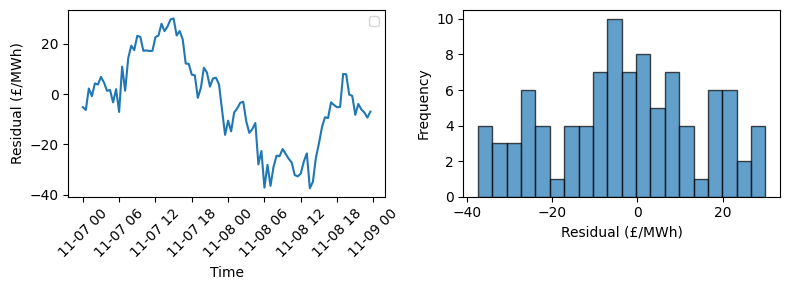

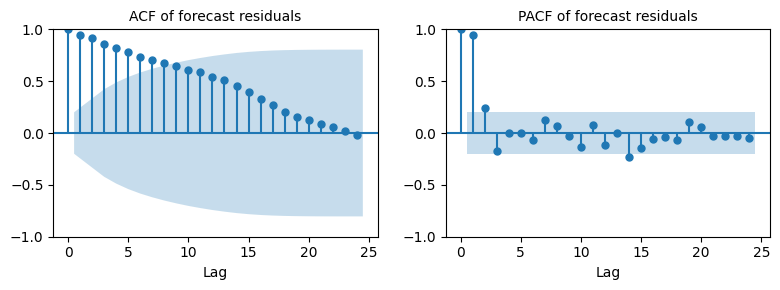

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

resi = point_forecast - endog_test
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")

ax1.plot(resi)
ax1.set_xlabel("Time", fontsize=10)
ax1.set_ylabel("Residual (£/MWh)", fontsize=10)
ax1.legend(fontsize=9)
ax1.tick_params(axis="x", labelrotation=45)

ax2.hist(resi, bins=20, edgecolor="black", alpha=0.7)
ax2.set_xlabel("Residual (£/MWh)", fontsize=10)
ax2.set_ylabel("Frequency", fontsize=10)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")
plot_acf(resi, lags=24, ax=ax1)
ax1.set_title("ACF of forecast residuals", fontsize=10)
ax1.set_xlabel("Lag", fontsize=10)

plot_pacf(resi, lags=24, ax=ax2)
ax2.set_title("PACF of forecast residuals", fontsize=10)
ax2.set_xlabel("Lag", fontsize=10)
plt.show()

### 3.1 Bootstrapping the residuals of the point forecast

To compute confidence intervals on the forecasts, conditional sieve
bootstrapping is used. The bootstrapping procedure goes as follows:

1. Get residuals $X_k$ from the fitted model
2. Fit a sieve / autoregressive model (AR($p$)) to the residuals $X_k$
3. Centre the residuals $\epsilon_k$ from the sieve to get $\hat{\epsilon}_k = \epsilon_k - \mu$
4. Bootstrap (with resampling) the centered residuals to get $\epsilon_k^{* (b)}$
5. Generate residual paths $X^{* (b)}_{k+1} = \sum^p_j{\hat{\phi}_j X^{* (b)}_{k+1-j}}+ \epsilon^{* (b)}_{k+1}$
6. Generate forecast paths $Y^{* (b)}_{k+1} = \hat{Y}_{k+1} + X^{* (b)}_{k+1}$

Validate that sieve bootstrapping is an acceptable method:


Mean of sieve residuals: 0.000000
Standard deviation of sieve residuals: 5.23


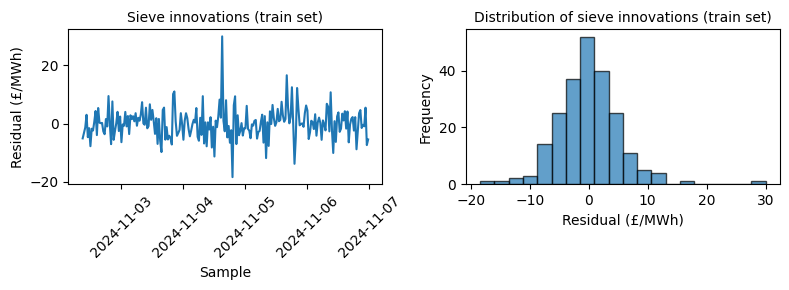

In [26]:
# Fit AR(p) sieve model to residuals
n = len(resi)
p_sieve = int(n / np.log(n) ** (1 / 4)) + 1
sieve_model = sm.tsa.AutoReg(train_resid, lags=p_sieve, old_names=False)
sieve_fitted = sieve_model.fit()
# print(f"\nSieve AR({p_sieve}) model summary:")
# print(sieve_fitted.summary())

# Get innovations (epsilon_k) from sieve and center them
sieve_resid = sieve_fitted.resid
epsilon_centered = sieve_resid - sieve_resid.mean()
print(f"\nMean of sieve residuals: {sieve_resid.mean():.6f}")
print(f"Standard deviation of sieve residuals: {sieve_resid.std():.2f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")
ax1.plot(epsilon_centered, label="Residuals")
ax1.set_xlabel("Sample", fontsize=10)
ax1.set_ylabel("Residual (£/MWh)", fontsize=10)
ax1.set_title("Sieve innovations (train set)", fontsize=10)
ax1.tick_params(axis="x", labelrotation=45)

ax2.hist(epsilon_centered, bins=20, edgecolor="black", alpha=0.7)
ax2.set_xlabel("Residual (£/MWh)", fontsize=10)
ax2.set_ylabel("Frequency", fontsize=10)
ax2.set_title("Distribution of sieve innovations (train set)", fontsize=10)
plt.show()

Run bootstrapping procedure:

In [27]:
from utilities.bootstrap import cond_sieve_bootstrap

n_bootstrap = 500  # Number of bootstrap samples

bootstrap_paths = cond_sieve_bootstrap(
    train_resid, point_forecast, n_bootstrap, seed=0
)

# Compute bootstrap confidence intervals
ci_lower = np.percentile(bootstrap_paths, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_paths, 97.5, axis=0)
ci_median = np.percentile(bootstrap_paths, 50, axis=0)
print(f"Bootstrap completed with {n_bootstrap} samples")
print(f"Mean CI width: {np.mean(ci_upper - ci_lower):.2f} £/MWh")

Bootstrap completed with 500 samples
Mean CI width: 21.76 £/MWh


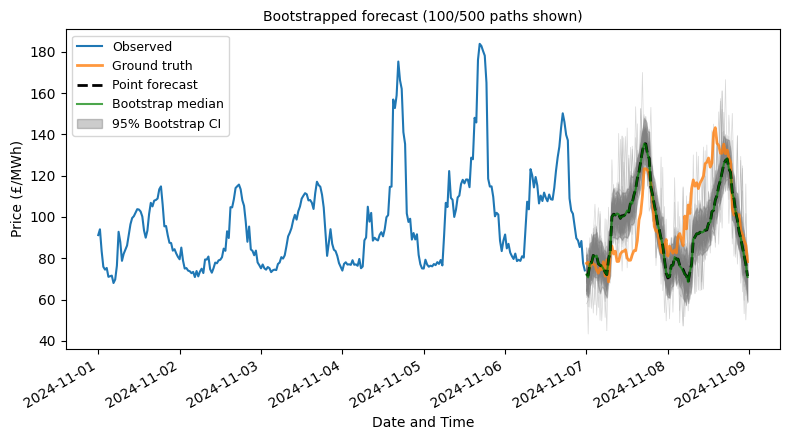

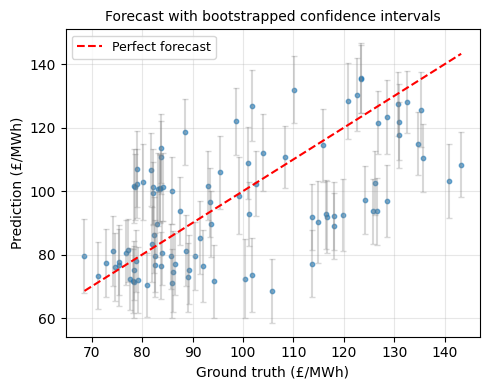

In [28]:
# Visualise bootstrap paths with timestamps
fig, ax = plt.subplots(figsize=(16 / 2, 9 / 2), layout="tight")

# Plot a sample of bootstrap paths
n_sample = 100
for b in range(n_sample):
    ax.plot(
        endog_test.index,
        bootstrap_paths[b, :],
        color="gray",
        alpha=0.3,
        linewidth=0.5,
    )

ax.plot(endog_train, label="Observed", color="C0")
ax.plot(endog_test, label="Ground truth", color="C1", linewidth=2, alpha=0.8)
ax.plot(point_forecast, "k--", label="Point forecast", linewidth=2)

# Plot confidence intervals
ax.plot(
    endog_test.index, ci_median,
    "g-", label="Bootstrap median", linewidth=1.5, alpha=0.7,
)
ax.fill_between(
    endog_test.index, ci_lower, ci_upper,
    color="k", alpha=0.2, label="95% Bootstrap CI",
)
ax.set_xlabel("Date and Time", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
ax.set_title(
    f"Bootstrapped forecast ({n_sample}/{n_bootstrap} paths shown)",
    fontsize=10,
)
ax.legend(fontsize=9, loc="best")
plt.xticks(rotation=30, ha="right")
plt.show()

# Scatter plot with bootstrapped uncertainties
fig, ax = plt.subplots(figsize=(5, 4), layout="tight")
scatter = ax.scatter(endog_test, point_forecast, alpha=0.6, s=10,)
ci_half_width = (ci_upper - ci_lower) / 2
ax.errorbar(
    endog_test, point_forecast, yerr=ci_half_width,
    fmt="none", ecolor="gray", alpha=0.3, capsize=2,
)

# Perfect forecast line
ax.plot(
    [endog_test.min(), endog_test.max()],
    [endog_test.min(), endog_test.max()],
    "r--",
    label="Perfect forecast",
)

ax.set_xlabel("Ground truth (£/MWh)", fontsize=10)
ax.set_ylabel("Prediction (£/MWh)", fontsize=10)
ax.set_title("Forecast with bootstrapped confidence intervals", fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.show()

## 4. Rolling day-ahead forecast evaluation

We now implement a rolling forecast where we:
1. Fit the model on a window of historical data
2. Forecast tomorrow's prices using NESO forecasts
3. Bootstrap the residuals to get confidence intervals
4. Update the model with latest observations and drop the oldest observations
5. Move on to the next day and repeat

In [29]:
# Rolling forecast parameters
n_train_samples = 48 * 7  # 1 week of training data
forecast_days = 7  # Number of day-ahead forecasts
n_bootstrap = 500  # Bootstrap samples per forecast

print("Rolling forecast configuration:")
print(f"  Training set size: {n_train_samples} samples")
print(f"  Forecast days: {forecast_days}")
print(f"  Bootstrap samples: {n_bootstrap}")

# Create issue times (period 18 = 08:30 London time)
start_time = pd.Timestamp("2024-11-01 08:30", tz="Europe/London")
end_time = start_time + pd.Timedelta(days=forecast_days)
issue_times = pd.date_range(start_time, end_time, freq="D")

print("\nTimestamps at which forecasts are issued:")
print(f"  First: {issue_times[0]}")
print(f"  Last: {issue_times[-1]}")
print(f"  Total: {len(issue_times)} days")

# Model specification
order = (1, 0, 1)
seasonal_order = (1, 0, 1, 48)

print("\nModel specification:")
print(f"  (p, d, q): {order}")
print(f"  (P, D, Q, S): {seasonal_order}")

Rolling forecast configuration:
  Training set size: 336 samples
  Forecast days: 7
  Bootstrap samples: 500

Timestamps at which forecasts are issued:
  First: 2024-11-01 08:30:00+00:00
  Last: 2024-11-08 08:30:00+00:00
  Total: 8 days

Model specification:
  (p, d, q): (1, 0, 1)
  (P, D, Q, S): (1, 0, 1, 48)


In [30]:
from utilities.forecast import Forecaster

class SARIMAXForecaster(Forecaster):
    """Day-ahead forecaster using SARIMAX."""

    def __init__(self, *, order, seasonal_order, **kwargs):
        super().__init__(**kwargs)
        self._order = order
        self._seasonal_order = seasonal_order
        self._result = None

    def _forecast_steps(self, steps, exog=None):
        return self._result.forecast(steps=steps, exog=exog)

    def _fit(self, endog, exog=None):
        if self._result is None:
            model = sm.tsa.SARIMAX(
                endog=endog,
                exog=exog,
                order=self._order,
                seasonal_order=self._seasonal_order,
            )
            self._result = model.fit(disp=False)
        else:
            self._result = self._result.apply(
                endog=endog, exog=exog, refit=True, copy_initialization=True
            )

    def _get_residuals(self):
        return np.asarray(self._result.resid)

In [31]:
forecaster = SARIMAXForecaster(
    order=order,
    seasonal_order=seasonal_order,
)

print("Running rolling forecast...")
results = forecaster.rolling_forecast_dayahead(
    df_train,
    df_test,
    issue_times,
    n_train_samples,
    percentiles=[2.5, 97.5],
    n_bootstrap=n_bootstrap,
)

# Summary statistics
rmse_val = np.sqrt(np.mean((results["forecast"] - results["actual"]) ** 2))
in_ci = (results["actual"] >= results["p2.5"]) & (
    results["actual"] <= results["p97.5"]
)
coverage = in_ci.mean() * 100

print("\n" + "=" * 50)
print("RESULTS SUMMARY")
print("=" * 50)
print(f"Total forecasts: {len(results)} periods")
print(f"RMSE: {rmse_val:.2f} £/MWh")
print(f"95% CI Coverage: {coverage:.1f}%")
print(
    f"Mean CI width: {(results['p97.5'] - results['p2.5']).mean():.2f} £/MWh"
)

Running rolling forecast...
[1/8] Forecasting from 2024-11-01 08:30:00+00:00
  RMSE: 13.04, MAE: 11.28
[2/8] Forecasting from 2024-11-02 08:30:00+00:00
  RMSE: 10.54, MAE: 8.86
[3/8] Forecasting from 2024-11-03 08:30:00+00:00
  RMSE: 23.09, MAE: 14.99
[4/8] Forecasting from 2024-11-04 08:30:00+00:00
  RMSE: 17.68, MAE: 14.55
[5/8] Forecasting from 2024-11-05 08:30:00+00:00
  RMSE: 24.14, MAE: 21.71
[6/8] Forecasting from 2024-11-06 08:30:00+00:00


/Users/christian/Projects/electricity_pricing/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  RMSE: 27.67, MAE: 25.45
[7/8] Forecasting from 2024-11-07 08:30:00+00:00
  RMSE: 21.63, MAE: 17.91
[8/8] Forecasting from 2024-11-08 08:30:00+00:00
  RMSE: 20.33, MAE: 19.32

RESULTS SUMMARY
Total forecasts: 384 periods
RMSE: 20.48 £/MWh
95% CI Coverage: 40.9%
Mean CI width: 23.60 £/MWh


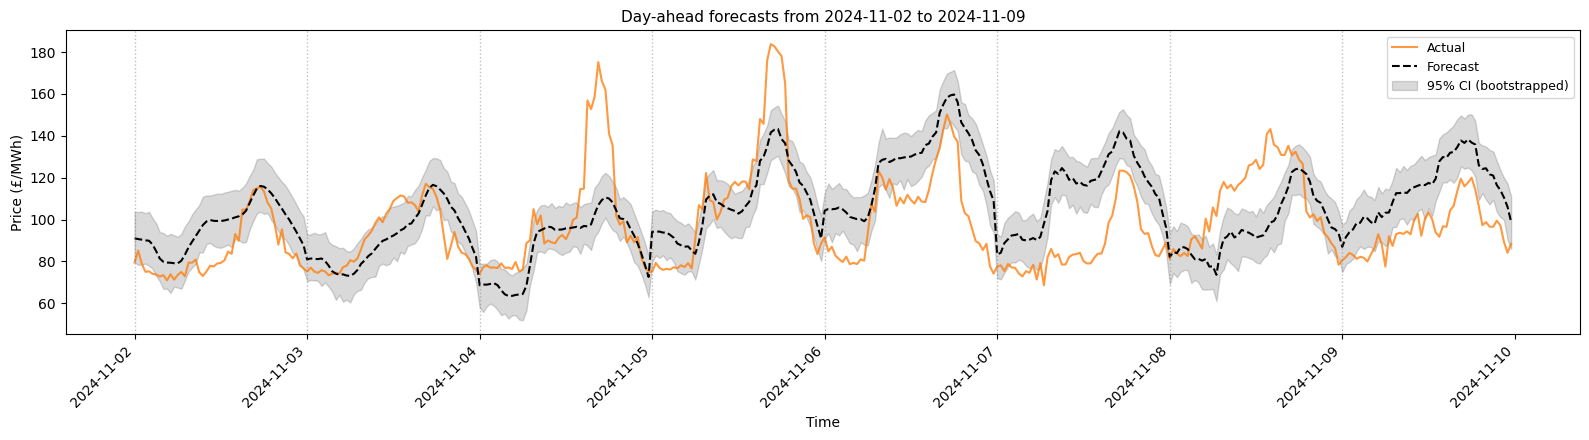

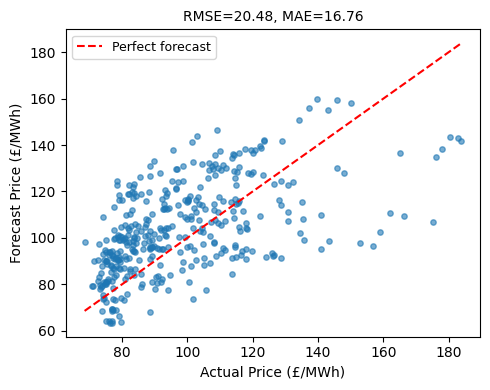

In [33]:
from utilities.evaluation import mae, rmse

ts = results.index  # timestamps

# Main time series plot with day boundaries
fig, ax = plt.subplots(figsize=(16, 9 / 2), layout="tight")
ax.plot(ts, results["actual"], "C1", label="Actual", linewidth=1.5, alpha=0.8)
ax.plot(ts, results["forecast"], "k--", label="Forecast", linewidth=1.5)

# Confidence intervals
ax.fill_between(
    ts, results["p2.5"], results["p97.5"],
    color="k", alpha=0.15, label="95% CI (bootstrapped)",
)

# Add vertical lines at midnight (day boundaries)
unique_dates = ts.normalize().unique()
for midnight in unique_dates:
    ax.axvline(midnight, color="gray", linestyle=":", alpha=0.5, linewidth=1)

# Labels and title
date_range = f"{unique_dates[0].date()} to {unique_dates[-1].date()}"
ax.set_xlabel("Time", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
ax.set_title(f"Day-ahead forecasts from {date_range}", fontsize=11)
ax.legend(fontsize=9, loc="best")
plt.xticks(rotation=45, ha="right")
plt.show()

# Scatter plot
fig, ax = plt.subplots(figsize=(5, 4), layout="tight")
scatter = ax.scatter(results["actual"], results["forecast"], alpha=0.6, s=15)
ax.plot(
    [results["actual"].min(), results["actual"].max()],
    [results["actual"].min(), results["actual"].max()],
    "r--",
    label="Perfect forecast",
    linewidth=1.5,
)

y_pred = np.asarray(results["forecast"])
y_true = np.asarray(results["actual"])
_rmse = rmse(y_pred, y_true)
_mae = mae(y_pred, y_true)
ax.set_xlabel("Actual Price (£/MWh)", fontsize=10)
ax.set_ylabel("Forecast Price (£/MWh)", fontsize=10)
ax.set_title(f"RMSE={_rmse:.2f}, MAE={_mae:.2f}", fontsize=10)
ax.legend(fontsize=9)
plt.show()